````{panels}
Voraussetzungen
^^^
- mathematische Grundlagen der Fouriertransformation
- Kenntnis von digitalen Filtern und Frequenzanalysen ({ref}`dft_intro`)
---

Lerninhalte
^^^
- Anwendung der DFT als digitaler Filter
````

(vuvuzela)=
# Vuvuzela Filter

Erinnern Sie sich noch an die WM 2010 in Südafrika?

<iframe width="560" height="315" src="https://www.youtube.com/embed/HFISx1j0kak?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>
<div style="text-align: left;font-size:80%;color:grey"> - Hinweis: Dieses Video ist von YouTube aus eingebunden und nicht Teil des frei lizenzierten Materials! - </div> <br>


```{admonition} Hinweis
Der Inhalt dieser Seite lässt sich nicht interaktiv online ausführen. 
```

**Wir entwickeln einen Vuvuzela Filter in 5 einfachen Schritten:**

 1. Wir nehmen einen Vuvuzela-Ton mit Matlab auf.
 2. Wir machen eine Frequenzanalyse unserer Aufnahme um die *Vuvuzela*-Frequenzen zu identifizieren.
 3. Wir enfwerfen einen Filter, der nur die Vuvuzela-Frequenzen aus dem Spektrum entfernt.
 4. Wir testen den Filter anhand unserer Aufnahme.
 
 5. Wir wenden den Filter auf eine Aufnahme der WM 2010 an um die Vuvuzelas aus dem Audiokanal zu entfernen oder zumindest etwas zu dämpfen.

## Schritt 1: Die Aufnahme

Packen Sie Ihre Vuvuzela aus! Wir können mit Matlab den *Vuvuzla*-Ton aufnehmen. Wir verwenden eine Samplingrate von $44,1\;\mathrm{kHz}$, eine Klangtiefe von $8\;\textrm{Bit}$ und wollen nur einen Kanal (Mono):

In [4]:
recordTime = 5;   % record for 5 seconds

recObj = audiorecorder(44100, 8, 1);
disp('Get ready...'); pause(1); disp('Set...'); pause(1);
disp('Recording...')
recordblocking(recObj, recordTime);
disp('            [Ok].');

Get ready...
Set...
Recording...
            [Ok].


Hat alles geklappt? Hören wir uns es mal an...

In [5]:
play(recObj);

Wir holen uns die Rohdaten der Aufnahme und betrachten das Signal im **Bildraum**:

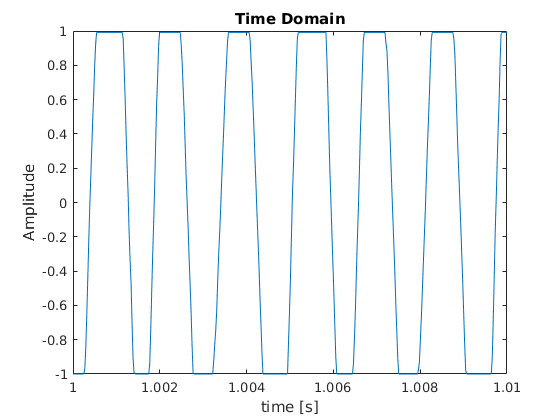

In [7]:
vuvuzela = getaudiodata(recObj);

N = length(vuvuzela);
time = (1:N)*recordTime/N;

plot(time, vuvuzela);
xlim([1,1.01])
title('Time Domain')
xlabel('time [s]')
ylabel('Amplitude')

Ok, das Signal ist eindeutig übersteuert. Die wesentlichen Frequenzen sind aber hoffentlich im Signal vorhanden.

## Schritt 2: Die Frequenzanalyse

Schauen wir uns das Signal im Frequenzraum an. Dazu berechnen wir erstmal die reellen Koeffizenten.

```{admonition} Hinweis
Das dient nur zur Anschauung, wir können auch alles mit den komplexen Koeffizienten machen.
```

In [8]:
Z = fft(vuvuzela);

%% OPTIONAL:

% convert integer frequencies to Hz
freq=(0:N-1)/recordTime;

% calculate real Fourier-coefficients from FFT
coeffs = [ 2*real(Z), -2*imag(Z)]/N;


Wir plotten die reellen Koeffizienten mit der Funktion `stem`. 

*Erinnerung: Das komplexe Spektrum ist konjugiert symmetrisch, daher reichen in der reellen Darstellung die ersten $N/2$ Koeffizienten.*

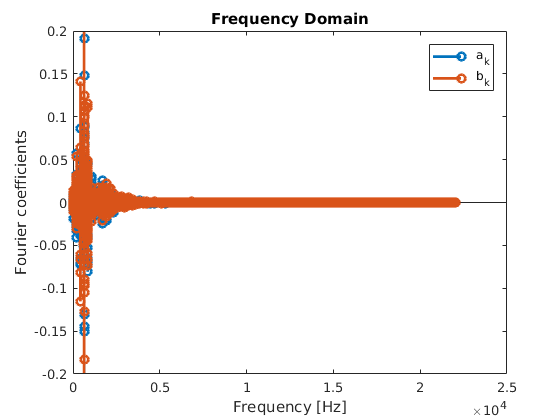

In [32]:
stem(freq(1:floor(N/2)), coeffs(1:floor(N/2),:),'LineWidth',2)
%xlim([0, 1200]); % zoom into the low frequencies
ylim([-0.2, 0.2]);
title('Frequency Domain')
xlabel('Frequency [Hz]')
ylabel('Fourier coefficients')
legend('a_k','b_k');

### Die *Vuvuzela*-Frequenzen

Aus dem Plot der Fourierkoeffizienten können wir die Frequenzen der Vuvuzela ablesen. Es gibt einen Grundton sowie mehrere Obertöne, die alle um eine bestimmte Frequenz normalverteilt sind.

Wir wollen nun einen Filter konstruieren, der im Frequenzraum arbeitet. Dazu wollen wir die folgenden *Vuvuzela*-Frequenzen `F`, jeweils mit einer kleinen Umgebung mit Radius `Fband` aus dem Spektrum entfernen:

In [20]:
F =     [240; 320; 475; 650; 800; 940; 1180]; % frequencies to be filtered
Fband = [ 50;  25;  50;  50;  60;  50;   50]; % radius of the frequency band


## Schritt 3: Filterkonstruktion

**Strategie:** Wir ordnen jeder Frequenz einen Multiplikator zu. Wollen wir die Frequenz behalten, ist der Multiplikator 1, wollen wir die Frequenz entfernen, ist der Multiplikator 0.

Um den Multiplikator zu konstruieren, verwenden wir die sogenannte logistische Funktion $f(x) = \frac{1}{1+e^{-k\cdot(x-x_0)}}$

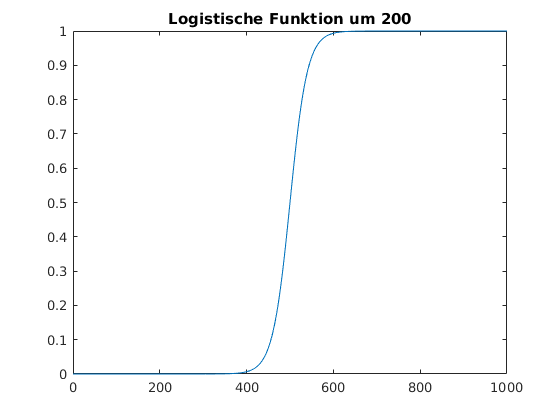

In [13]:
logistic = @(k, x0, x) 1./(1+exp(-k*(x-x0)));

% plot an example
x = linspace(0,1000,1000); 
plot(x, logistic(0.05, 500, x));
title('Logistische Funktion um 200')

Betrachten wir ein Beispiel, wie man mit der logistischen Funktion einen *Notch*-Filter konstruieren kann:

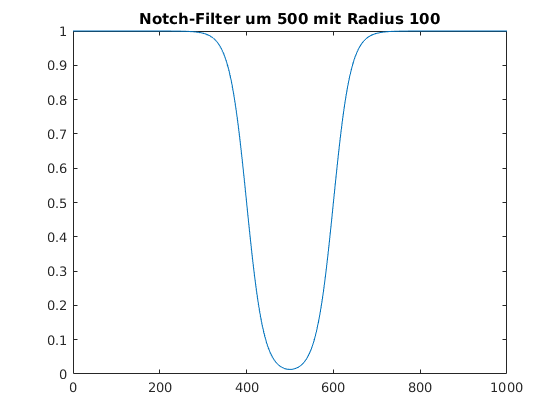

In [17]:
plot(x, 1 - logistic(0.05, 400, x) + logistic(0.05 ,600, x)); 
title('Notch-Filter um 500 mit Radius 100')

### Nebenbei:

Neben zwei logistischen Funktionen haben wir viele andere Optionen:
 - Wir könnten **zwei kubische Polynome** verwenden.
 - Wir könnten direkt eine (negative) **Gaußglocke** nehmen. $\rightarrow$ Nah an der Physik
 - Wir könnten eine **Dreiecksfunktion** verwenden.
 - Wir könnten eine **Rechtecksfunktion** verwenden.
 - ...

Wir definieren uns mit der logistischen Funktion einen Multiplikator, der die Vuvuzela--Frequenzen *sanft* aus dem Spektrum entfernt:

In [21]:
multiplier = ones(size(freq));
for k = 1:length(F)
    multiplier = multiplier - logistic(0.125, F(k)-Fband(k), freq);
    multiplier = multiplier + logistic(0.125, F(k)+Fband(k), freq);
end

% make sure the multiplier takes values in [0,1]
multiplier = max(0,multiplier);
multiplier = min(1,multiplier);

% make sure that the filter is symmetric
multiplier(end:-1:end - floor(N/2)) = multiplier(1:floor(N/2)+1);

Wie sieht unser Notch-Filter aus?

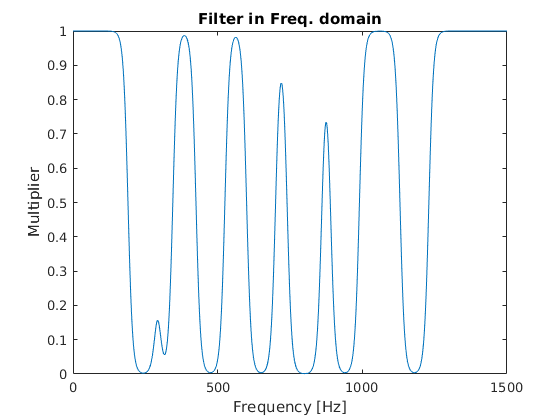

In [25]:
plot(freq, multiplier)
xlim([0, 1500]) % zoom into the low frequencies
title('Filter in Freq. domain');
xlabel('Frequency [Hz]')
ylabel('Multiplier')

## Schritt 4: Testen des Filters an der ursprünglichen Aufnahme

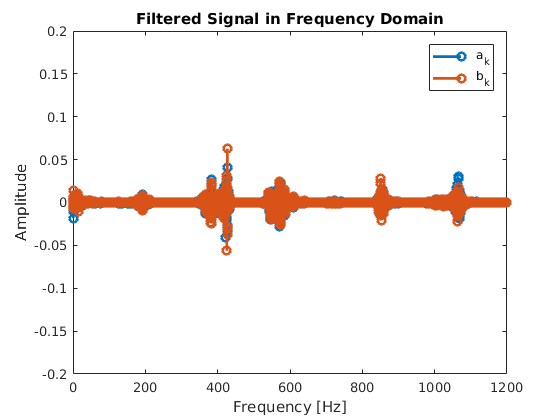

In [26]:
% apply filter to real Fourier coefficients
filteredsignal = [multiplier'.*coeffs(:,1) multiplier'.*coeffs(:,2)];

% plot the filtered coefficients
stem(freq(1:floor(N/2)), filteredsignal(1:floor(N/2),:),'LineWidth',2)
xlim([0, 1200])
ylim([-0.2, 0.2]);
title('Filtered Signal in Frequency Domain');
xlabel('Frequency [Hz]')
ylabel('Amplitude')
legend('a_k','b_k');

Wir haben die *Vuvuzela*-Frequenzen aus dem Spektrum entfernt. Wie klingt die Aufnahme jetzt?

Dazu müssen wir zurücktransformieren und uns das Ergebnis mit `soundsc` wiedergeben lassen. Wir verwenden die Samplingrate des Aufnahmegerätes.

In [27]:
% apply the multiplier and do the inverse Fouriertransform
vuvuzela_filtered = ifft(multiplier'.*Z);

% due to numerical round-off errors, we have a small imaginary contributation, that can be ignored.
vuvuzela_filtered = real(vuvuzela_filtered);

% play the original recording
disp("Original recording")
soundsc(vuvuzela, recObj.sampleRate); pause(recordTime);

% play the filtered recording
disp("Filtered recording")
soundsc(vuvuzela_filtered, recObj.sampleRate); pause(recordTime);

Original recording
Filtered recording


## Schritt 5: Wenden wir den Filter an einem Beispiel an

<iframe width="560" height="315" src="https://www.youtube.com/embed/HFISx1j0kak?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>

<div style="text-align: left;font-size:80%;color:grey"> - Hinweis: Dieses Video ist von YouTube aus eingebunden und nicht Teil des frei lizenzierten Materials! - </div> <br>


**Wir haben da mal etwas vorbereitet...** und die Tonspur des vorherigen Videos als mp3 heruntergeladen. Diese lässt sich mit Matlab importieren.

In [29]:
soundfile = 'Vuvuzela_Tshabalala_Goal.mp3';

startTime = 0;
endTime   = 5;
Fs = 44100;

% read a fraction of the sound file
samples = Fs*[startTime + 1/Fs, endTime];
youtubeSound = audioread(soundfile, samples);

%convert stereo to mono by avaraging the two signals
youtubeSound = mean(youtubeSound,2);

Unser Filter lässt sich nun durch nur eine Zeile Code anwenden.

In [30]:
% a) calculate Fouriertransform
% b) apply the filter (multiply by multiplier)
% c) calculate inverse Fouriertransform
% d) take real part due to round-of errors
youtubeSoundFiltered = real( ifft( multiplier'.*fft(youtubeSound) ) );

% play the original recording
disp("Original recording")
soundsc(youtubeSound, 44100); pause(recordTime);

% play the filtered recording
disp("Filtered recording")
soundsc(youtubeSoundFiltered, 44100); pause(recordTime);

Original recording
Filtered recording


## Reproduzierbarkeit

Um später nachvollziehen zu können,
 - auf welchen Frequenzen unser Vuvuzela-Filter basiert und
 - auf Basis welcher Aufnahme wir die Frequenzen ausgewählt haben
 
sollten wir unser *Matlab-Workspace* in einer Datei abspeichern.

In [31]:
save(['vuvuzela_filter_', datestr(now,'yyyy_mm_dd-HH_MM_SS'), '.mat'])

### Abschließende Bemerkungen

 - Wir haben einen sehr naiven Notch-Filter-Ansatz verwendet, moderne Filter in der Tontechnik sind viel komplizierter.
 - Nichtsdestotrotz finden die meisten Filter direkt im Frequenzraum statt und Notch-Filter, wenn auch etwas komplexer, finden eine weite Anwendung.

### Kommentare zum Matlab-Beispiel:
 - Im präsentierten Beispiel hat das Signal des Youtube-Videos dieselbe Länge wie die Vuvuzela-Aufnahme, da wir ein gleichgroßes Zeitfenster von 5 Sekunden und dieselbe Abtastfrequenz von 44,1 kHz verwenden. 
 - Wenn wir den Filter auf ein längeres Video anwenden wollen, müssen wir den Multiplier neu ausrechnen, damit er die korrekte Länge hat. Am besten schreibt man sich eine Funktion `multiplier = function(F, Fband, freq)` um Code-Dopplung zu vermeiden.